## Activating GPU for Tensorflow

Allow Tensorflow to use GPU to speed up model training

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

## Importing Libraries

In [ ]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import random as rn
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.callbacks import ModelCheckpoint

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

This dataset contains 4242 images of flowers.The data collection is based on the data flicr, google images, yandex images.We can use this datastet to recognize plants from the photo.The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion. For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions.

## Data Loading

Load data from their directories and then labeling the data with their flower types

In [ ]:
data=[]
labels=[]
IMG_SIZE=224
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'

In [ ]:
def assign_label(img,flower_type):
    return flower_type

In [ ]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        data.append(np.array(img))
        labels.append(str(label))

In [ ]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(data))

100%|██████████| 764/764 [00:02<00:00, 375.33it/s]

764


In [ ]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(data))

100%|██████████| 733/733 [00:02<00:00, 323.52it/s]

1497


In [ ]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(data))

100%|██████████| 984/984 [00:02<00:00, 352.13it/s]

2481


In [ ]:
make_train_data('Dandelion',FLOWER_DANDI_DIR)
print(len(data))

100%|██████████| 1052/1052 [00:02<00:00, 365.44it/s]

3533


In [ ]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(data))

100%|██████████| 784/784 [00:02<00:00, 368.71it/s]

4317


## Data Understanding

In [ ]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

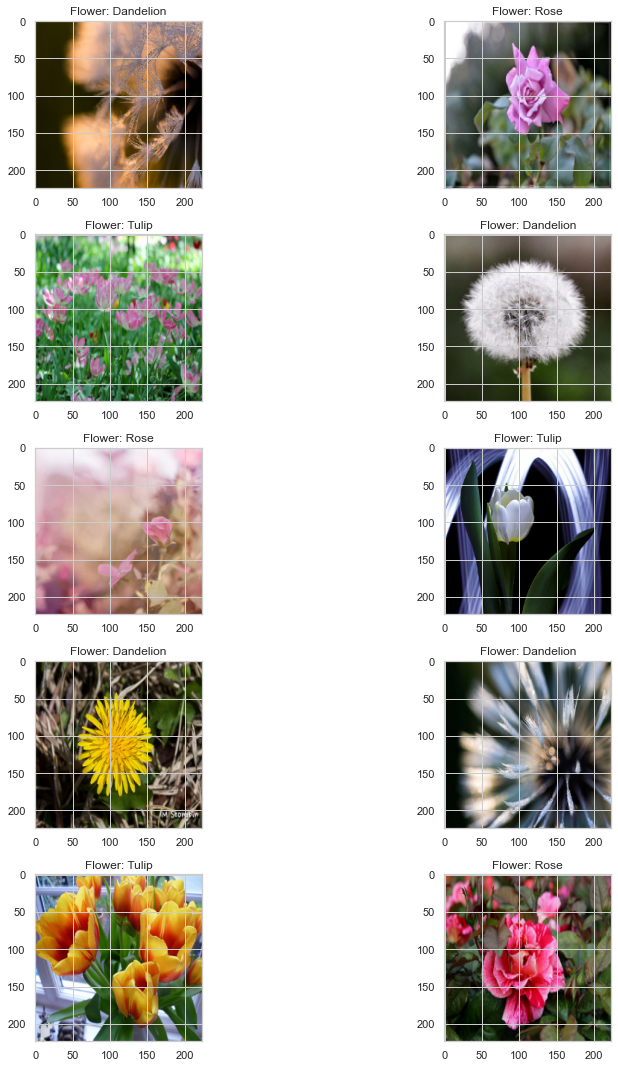

In [ ]:
# Randomly Previewing first 10 images
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)

for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(data))
        ax[i,j].imshow(cvtRGB(data[l]))
        ax[i,j].set_title('Flower: '+labels[l])
        
plt.tight_layout()

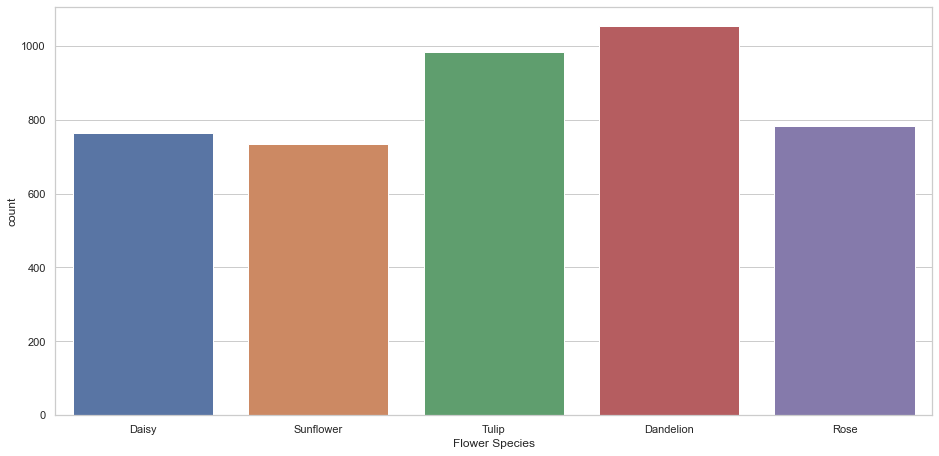

In [ ]:
# Class disribution
categories=['Daisy', 'Sunflower', 'Tulip', 'Dandelion', 'Rose']
sns.set_style('whitegrid')
plt.figure(figsize=(14,7))
fig=sns.countplot(labels)
fig.set(xticks=range(len(categories)), xticklabels=[i for i in categories])
plt.xlabel('Flower Species')
plt.show()

In [ ]:
list_daisy=len([i for i in labels if i=='Daisy'])
list_sunflower=len([i for i in labels if i=='Sunflower'])
list_tulip=len([i for i in labels if i== 'Tulip'])
list_dandelion=len([ i for i in labels if i== 'Dandelion'])
list_rose=len([i for i in labels if i== 'Rose'])

In [ ]:
list_species=[list_daisy, list_sunflower, list_tulip, list_dandelion, list_rose]

In [ ]:
number = pd.DataFrame(
    {'Flower': categories,
     'Total': list_species
    })

In [ ]:
number

Flower  Total
0      Daisy    764
1  Sunflower    733
2      Tulip    984
3  Dandelion   1052
4       Rose    784

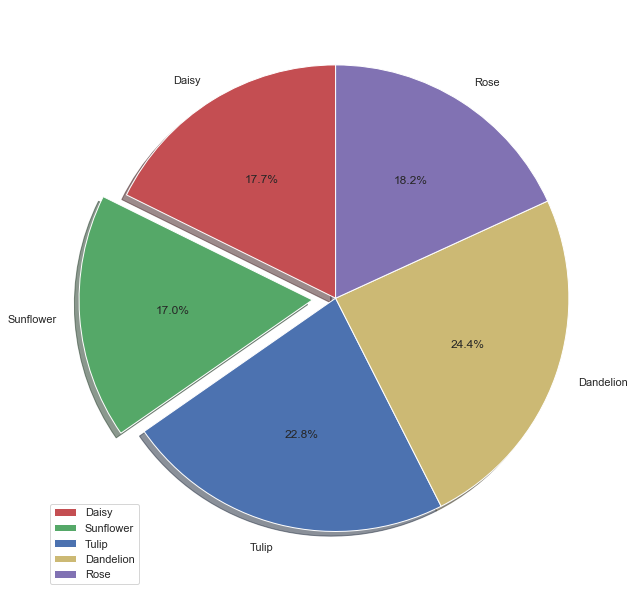

In [ ]:
# The dataset seems to be balanced
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.pie(list_species,labels=categories,startangle=90,colors=['r','g','b','y','m'],autopct='%1.1f%%',explode = (0, 0.1, 0, 0,0),shadow=True)
plt.legend()
plt.show()

In [ ]:
# LabelEncoding:To deal with categorical values we need to preprocess it using label ecnoding
le=LabelEncoder()
Y=le.fit_transform(labels)
Y=to_categorical(Y,5)
X=np.array(data)
X=X/255

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

We concatenate these 5 dataframes and perfrom onehotencoding. Data exploration is conducted so we wont end up creating imbalanced dataframes that'll lead us to bad prediction.

So, we are splitting the different flower dataframes into 80-20 train test split fashion and then adding them into a train and a test dataframe and followed by shuffling the data and creating final data for prediction.

## Model Creation

In [ ]:
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array

The train_images was added by sequence from sub-folders so we need to shuffle the dataset. Otherwise, the model can only learn what is “daisy” from the first 800 images, which wouldn't optimise the parameters of the model. Note that the seed need to be set and applied to both train_images and train_labels so that each image can match the right label.

In [ ]:
seed = 100
np.random.seed(seed)
np.random.shuffle(x_train)
np.random.seed(seed)
np.random.shuffle(x_test)
np.random.seed(seed)
np.random.shuffle(y_train)
np.random.seed(seed)
np.random.shuffle(y_test)

In [ ]:
print('shape of x_train:', x_train.shape)
print('shape of x_test:', x_test.shape)
print('shape of y_train:', y_train.shape)
print('shape of y_test:', y_test.shape)

shape of x_train: (3453, 224, 224, 3)
shape of x_test: (864, 224, 224, 3)
shape of y_train: (3453, 5)
shape of y_test: (864, 5)


In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


### Resnet50 

Pre trained deep learning models makes life easy and simple as we do not need to build our model from scratch.

In [ ]:
resnet_weights_path = r"C:\Users\kahki\Desktop\IP Assignment\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
categories = 5
def create_model_from_ResNet50():
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(categories, activation='softmax'))

    # Not to train first layer (ResNet) model. It is already trained
    # Add two customised layers --> two dense functions with size 2048 & 1024 accompanying ‘ReLU’ activation function.
    model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # optimizer=RMSprop(lr=0.001)
    
    return model

In [ ]:
with strategy.scope():
    model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)             

In [ ]:
import tensorflow as tf
import pydot
tf.keras.utils.plot_model(model_ResNet50, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### SqueezeNet Inspired Model

In [ ]:
def fire(x, squeeze, expand):
  y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x) 
  y = tf.keras.layers.BatchNormalization(momentum=0.9)(y)
  y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
  y1 = tf.keras.layers.BatchNormalization(momentum=0.9)(y1)
  y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
  y3 = tf.keras.layers.BatchNormalization(momentum=0.9)(y3)
  return tf.keras.layers.concatenate([y1, y3])

# this is to make it behave similarly to other Keras layers
def fire_module(squeeze, expand):
  return lambda x: fire(x, squeeze, expand)

l = tf.keras.layers
x = tf.keras.layers.Input(shape=[IMG_SIZE,IMG_SIZE, 3]) # input is 192x192 pixels RGB

y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
y = tf.keras.layers.BatchNormalization(momentum=0.9)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
y = fire_module(24, 48)(y)
y = tf.keras.layers.GlobalAveragePooling2D()(y)
y = tf.keras.layers.Dense(5, activation='softmax')(y)



In [ ]:
with strategy.scope():
    model_SqueezeNetInspired = tf.keras.Model(x, y)
    model_SqueezeNetInspired.compile(optimizer= "adam",loss='categorical_crossentropy',metrics=['accuracy'])
model_SqueezeNetInspired.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 24) 792         batch_normalization[0][0]        
______________________________________________________________________________________________

### VGG19

In [ ]:
pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

In [ ]:
with strategy.scope():
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:
        layer.trainable = False

    model_VGG19 = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model_VGG19.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    # define the checkpoint
    filepath = "model.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
model_VGG19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 23045     
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


### Data Augmentation

One way to prevent overfitting is to create more data, through data augmentation. This refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating. It is the technique used to overome the problem of overfitting and make our model to generalize well on the unseen data.

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

## Model Running 

### ResNet50

In [ ]:
batch_size=32
epochsResNet=30
model_ResNet50_info = model_ResNet50.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochsResNet, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/30
107/107 [==============================] - 26s 215ms/step - loss: 2.3468 - accuracy: 0.3938 - val_loss: 1.7972 - val_accuracy: 0.2188
Epoch 2/30
107/107 [==============================] - 22s 205ms/step - loss: 1.3355 - accuracy: 0.4930 - val_loss: 1.6619 - val_accuracy: 0.2627
Epoch 3/30
107/107 [==============================] - 22s 203ms/step - loss: 1.2207 - accuracy: 0.5383 - val_loss: 1.4384 - val_accuracy: 0.3762
Epoch 4/30
107/107 [==============================] - 22s 204ms/step - loss: 1.2082 - accuracy: 0.5439 - val_loss: 1.1752 - val_accuracy: 0.5336
Epoch 5/30
107/107 [==============================] - 22s 205ms/step - loss: 1.1677 - accuracy: 0.5594 - val_loss: 1.1989 - val_accuracy: 0.5243
Epoch 6/30
107/107 [==============================] - 22s 204ms/step - loss: 1.1198 - accuracy: 0.5597 - val_loss: 1.2303 - val_accuracy: 0.5683
Epoch 7/30
107/107 [==============================] - 22s 205ms/step - loss: 1.2028 - accuracy: 0.5499 - val_loss: 1.1338 - val_ac

### SqueezeNet Inspired Model

In [ ]:
batch_size=16
epochsSqueezeNet=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)


model_SqueezeNetInspired_info = model_SqueezeNetInspired.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs =epochsSqueezeNet, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/50
215/215 [==============================] - 29s 118ms/step - loss: 1.2382 - accuracy: 0.4876 - val_loss: 1.0505 - val_accuracy: 0.5949
Epoch 2/50
215/215 [==============================] - 24s 111ms/step - loss: 1.1120 - accuracy: 0.5607 - val_loss: 1.0498 - val_accuracy: 0.5914
Epoch 3/50
215/215 [==============================] - 24s 111ms/step - loss: 1.0666 - accuracy: 0.5743 - val_loss: 1.0239 - val_accuracy: 0.6262
Epoch 4/50
215/215 [==============================] - 24s 111ms/step - loss: 1.0355 - accuracy: 0.5959 - val_loss: 0.8957 - val_accuracy: 0.6597
Epoch 5/50
215/215 [==============================] - 24s 112ms/step - loss: 0.9854 - accuracy: 0.6282 - val_loss: 0.9605 - val_accuracy: 0.6447
Epoch 6/50
215/215 [==============================] - 24s 110ms/step - loss: 0.9406 - accuracy: 0.6334 - val_loss: 0.9747 - val_accuracy: 0.6574
Epoch 7/50
215/215 [==============================] - 24s 111ms/step - loss: 0.9203 - accuracy: 0.6459 - val_loss: 0.8886 - val_ac

### VGG19

In [ ]:
batch_size=16
epochsVGG19=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

model_VGG19_info = model_VGG19.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochsVGG19, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size, callbacks=callbacks_list)


Epoch 1/50
215/215 [==============================] - 32s 127ms/step - loss: 1.1419 - accuracy: 0.5702 - val_loss: 0.5429 - val_accuracy: 0.7894

Epoch 00001: loss improved from inf to 0.86202, saving model to model.h5
Epoch 2/50
215/215 [==============================] - 23s 105ms/step - loss: 0.5477 - accuracy: 0.8098 - val_loss: 0.4262 - val_accuracy: 0.8507

Epoch 00002: loss improved from 0.86202 to 0.55258, saving model to model.h5
Epoch 3/50
215/215 [==============================] - 22s 104ms/step - loss: 0.4627 - accuracy: 0.8363 - val_loss: 0.4343 - val_accuracy: 0.8553

Epoch 00003: loss improved from 0.55258 to 0.46733, saving model to model.h5
Epoch 4/50
215/215 [==============================] - 23s 105ms/step - loss: 0.4230 - accuracy: 0.8563 - val_loss: 0.4068 - val_accuracy: 0.8576

Epoch 00004: loss improved from 0.46733 to 0.43195, saving model to model.h5
Epoch 5/50
215/215 [==============================] - 23s 105ms/step - loss: 0.3668 - accuracy: 0.8694 - val_los

215/215 [==============================] - 22s 104ms/step - loss: 0.1502 - accuracy: 0.9609 - val_loss: 0.8188 - val_accuracy: 0.8819

Epoch 00040: loss did not improve from 0.07586
Epoch 41/50
215/215 [==============================] - 22s 104ms/step - loss: 0.1107 - accuracy: 0.9739 - val_loss: 0.7508 - val_accuracy: 0.8866

Epoch 00041: loss did not improve from 0.07586
Epoch 42/50
215/215 [==============================] - 23s 105ms/step - loss: 0.0602 - accuracy: 0.9828 - val_loss: 0.7811 - val_accuracy: 0.8854

Epoch 00042: loss improved from 0.07586 to 0.06363, saving model to model.h5
Epoch 43/50
215/215 [==============================] - 22s 105ms/step - loss: 0.0660 - accuracy: 0.9735 - val_loss: 0.9040 - val_accuracy: 0.8866

Epoch 00043: loss improved from 0.06363 to 0.05487, saving model to model.h5
Epoch 44/50
215/215 [==============================] - 22s 104ms/step - loss: 0.0575 - accuracy: 0.9843 - val_loss: 1.0183 - val_accuracy: 0.8762

Epoch 00044: loss did not imp

## Results

In [ ]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')

  
  # summarize history for loss
  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
    
  plt.show()

### ResNet50

model_ResNet50


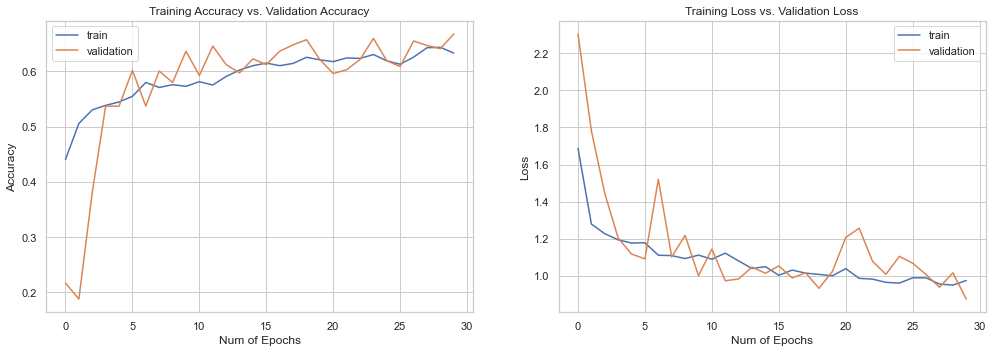

In [ ]:
plot_model_history('model_ResNet50', model_ResNet50_info, epochsResNet)

By using the transfer model (resnet50)method. The range of the val_acc is 60%-70%.

### SqueezeNet Inspired

model_SqueezeNetInspired


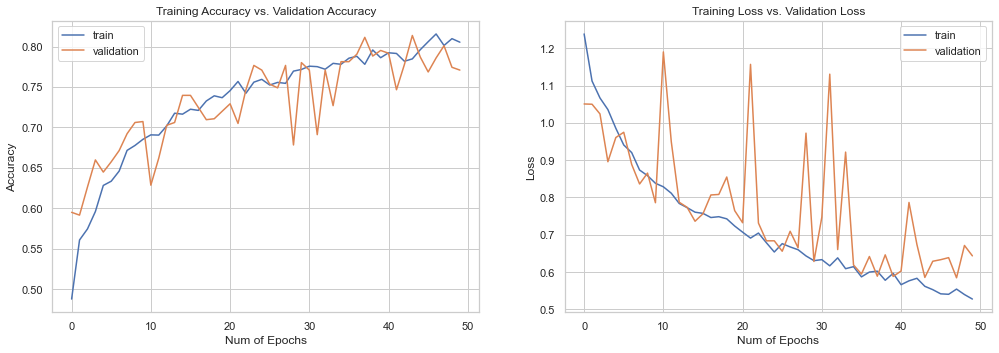

In [ ]:
plot_model_history('model_SqueezeNetInspired', model_SqueezeNetInspired_info, epochsSqueezeNet)

### VGG19

In [ ]:
plot_model_history('model_VGG19', model_VGG19_info, epochsVGG19)

model_VGG19


## Model Output Examples

### ResNet50

In [ ]:
# getting predictions on val set.
resnet_pred=model_ResNet50.predict(x_test)
resnet_pred_digits=np.argmax(resnet_pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==resnet_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==resnet_pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(x_test[prop_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([resnet_pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(x_test[mis_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([resnet_pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

### SqueezeNet Inspired Model

In [ ]:
# getting predictions on val set.
squeezenet_pred=model_SqueezeNetInspired.predict(x_test)
squeezenet_pred_digits=np.argmax(squeezenet_pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==squeezenet_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==squeezenet_pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

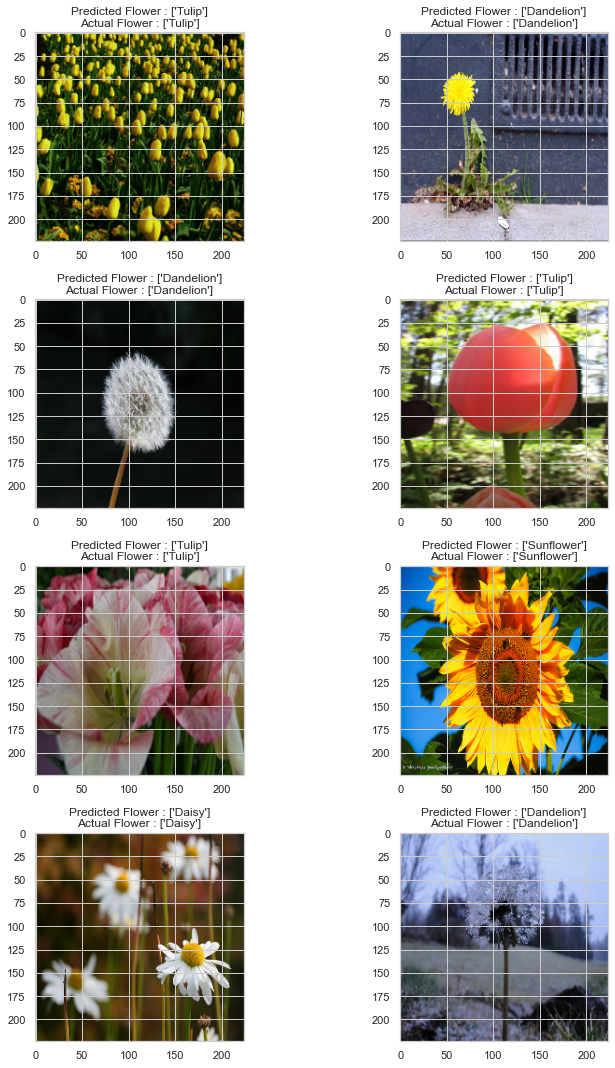

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(x_test[prop_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([squeezenet_pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

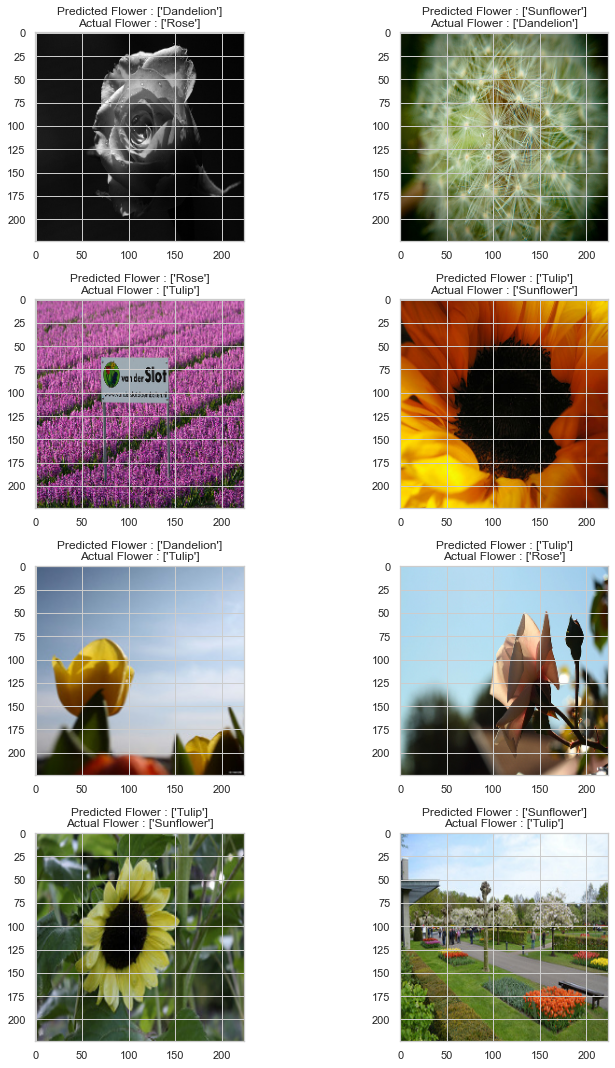

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(x_test[mis_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([squeezenet_pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

### VGG19

In [ ]:
# getting predictions on val set.
vgg19_pred=model_VGG19.predict(x_test)
vgg19_pred_digits=np.argmax(vgg19_pred,axis=1)

In [ ]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==vgg19_pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==vgg19_pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

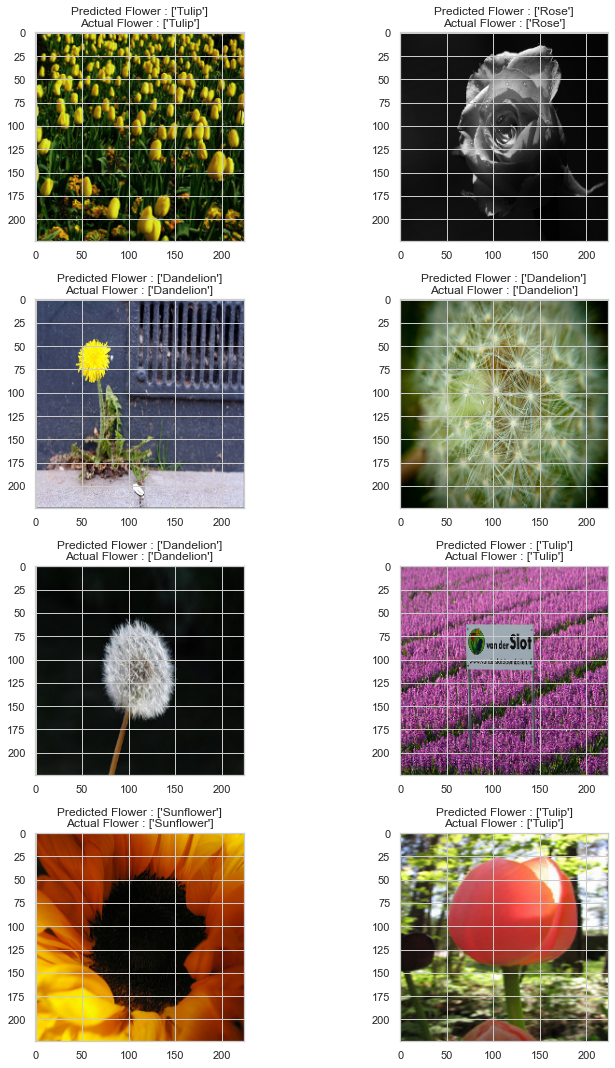

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(x_test[prop_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([vgg19_pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

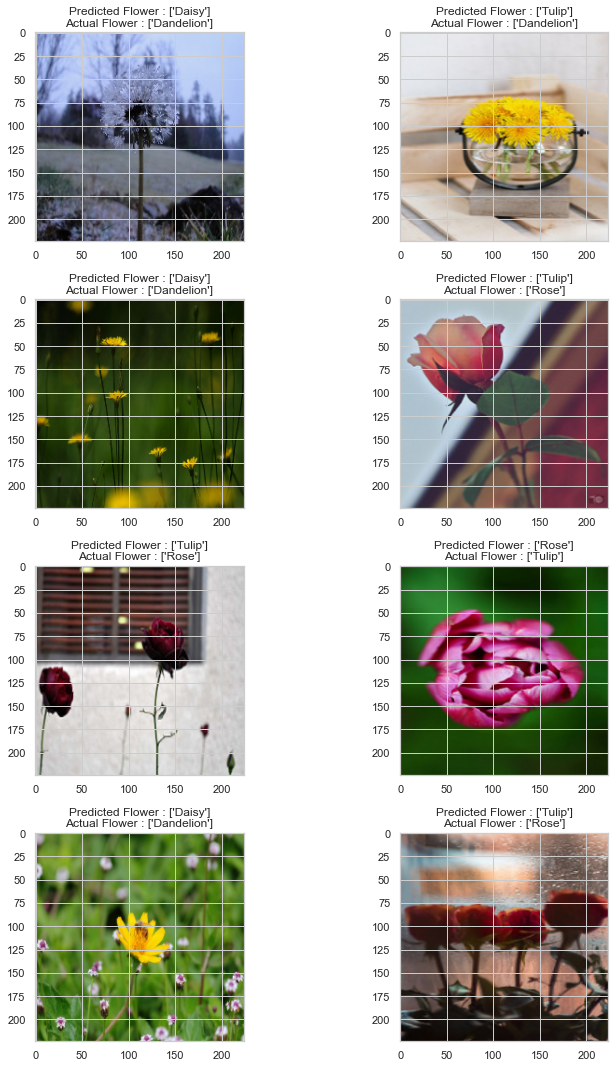

In [ ]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(cvtRGB(x_test[mis_class[count]].astype('float32')))
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([vgg19_pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1

## Model Confusion Matrix and Classification Report

In [ ]:
def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title = 'Confusion matrix',
                              cmap = plt.cm.ocean):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

def disp_confusion_matrix(y, y_pred, model_name):

    cm = confusion_matrix(y, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes= le.inverse_transform([0, 1, 2, 3, 4]), normalize=False, 
                                 title = model_name + '\nConfusion Matrix')
    plt.show()

### ResNet50

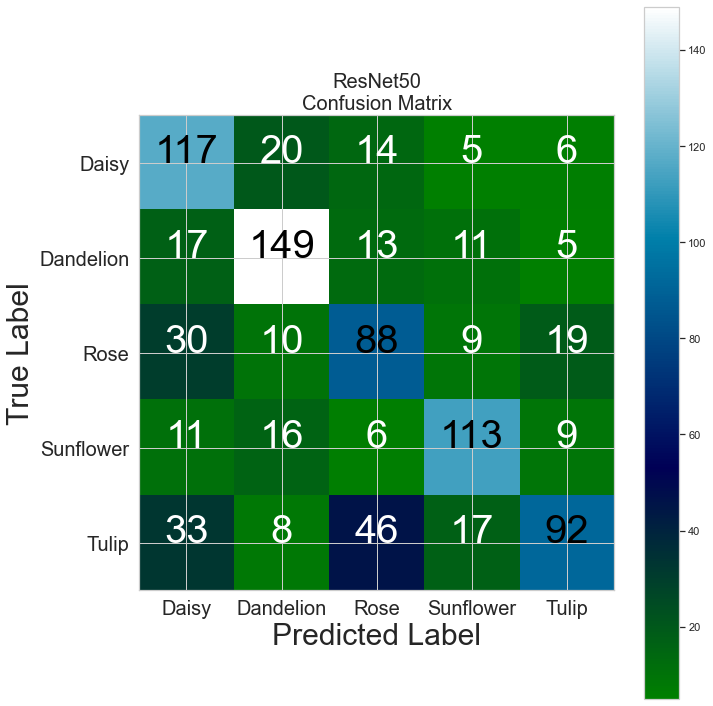

In [ ]:
import numpy as np
import itertools
y_test_arg=np.argmax(y_test,axis=1)
y_pred_arg=np.argmax(resnet_pred,axis=1)
disp_confusion_matrix(y_test_arg, y_pred_arg, "ResNet50")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.59      0.70      0.64       162
           1       0.71      0.74      0.73       195
           2       0.69      0.50      0.58       156
           3       0.73      0.75      0.74       155
           4       0.63      0.64      0.63       196

    accuracy                           0.67       864
   macro avg       0.67      0.67      0.66       864
weighted avg       0.67      0.67      0.67       864



### SqueezeNet Inspired Model

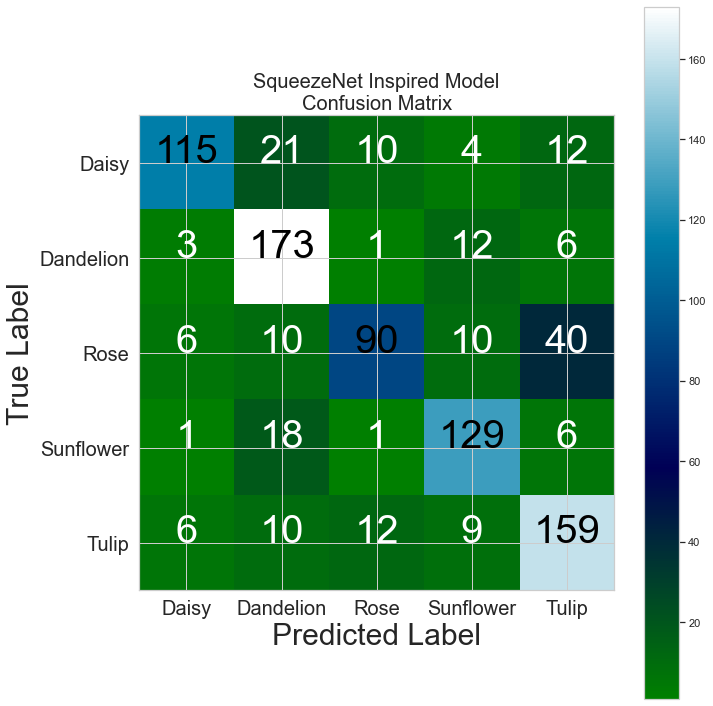

In [ ]:
import numpy as np
import itertools
y_test_arg=np.argmax(y_test,axis=1)
y_pred_arg=np.argmax(squeezenet_pred,axis=1)
disp_confusion_matrix(y_test_arg, y_pred_arg, "SqueezeNet Inspired Model")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.88      0.71      0.78       162
           1       0.75      0.89      0.81       195
           2       0.79      0.58      0.67       156
           3       0.79      0.83      0.81       155
           4       0.71      0.81      0.76       196

    accuracy                           0.77       864
   macro avg       0.78      0.76      0.77       864
weighted avg       0.78      0.77      0.77       864



### VGG19

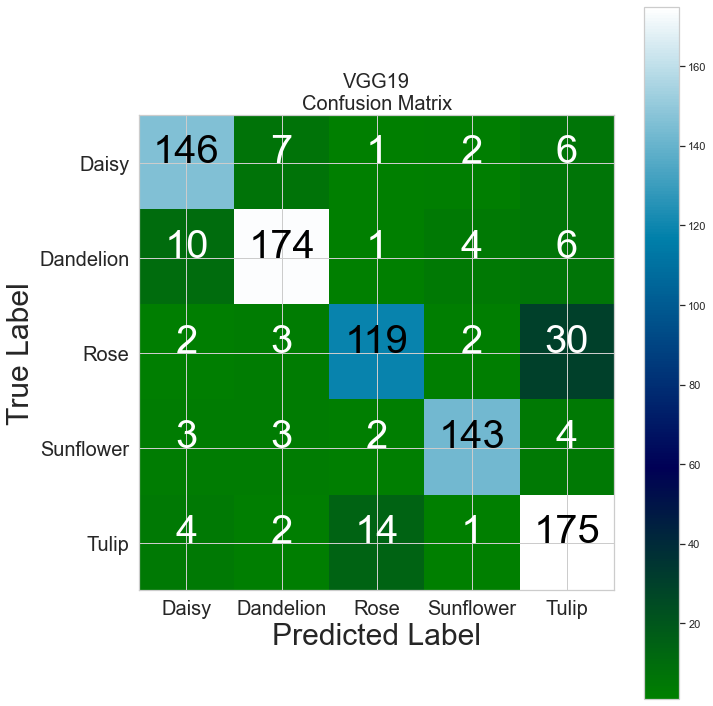

In [ ]:
import numpy as np
import itertools
y_test_arg=np.argmax(y_test,axis=1)
y_pred_arg=np.argmax(vgg19_pred,axis=1)
disp_confusion_matrix(y_test_arg, y_pred_arg, "VGG19")

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_arg, y_pred_arg))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       162
           1       0.92      0.89      0.91       195
           2       0.87      0.76      0.81       156
           3       0.94      0.92      0.93       155
           4       0.79      0.89      0.84       196

    accuracy                           0.88       864
   macro avg       0.88      0.87      0.88       864
weighted avg       0.88      0.88      0.88       864



In [ ]:
# model_ResNet50.save(r"C:\Users\kahki\Desktop\IP Assignment\Resnet50")

In [ ]:
# print(model_ResNet50.summary())

In [ ]:
# model_SqueezeNetInspired.save(r"C:\Users\kahki\Desktop\IP Assignment\SqueezeNet")

In [ ]:
# print(model_SqueezeNetInspired.summary())

In [ ]:
# model_VGG19.save(r"C:\Users\kahki\Desktop\IP Assignment\VGG19")

In [ ]:
# print(model_VGG19.summary())